In [1]:
'''
PRUEBAS
ratings[(ratings["userId"]==1) & (ratings["rating"]>=5.0)]
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import operator

In [2]:
# FUNCIONES
def Manhattan(myUser,MaxUser,lista):
    distancia={}
    for user in range (1,MaxUser+1):
        temp=lista[[myUser,str(user)]]
        temp=temp.dropna()
        if str(user)!=myUser:
            if temp.shape[0]==0:
                distancia[str(user)]=9999999.9
            else:
                distancia[str(user)]=(temp[myUser]-temp[str(user)]).abs().sum()
            
    return distancia
    
def Euclidiana(myUser,MaxUser,lista):
    distancia={}
    for user in range (1,MaxUser+1):
        temp=lista[[myUser,str(user)]]
        temp=temp.dropna()
        if str(user)!=myUser:
            if temp.shape[0]==0:
                distancia[str(user)]=9999999.9
            else:
                distancia[str(user)]=np.sqrt(((temp[myUser]-temp[str(user)])**2).sum())
            
    return distancia         
        
def Pearson(myUser,MaxUser,lista):
    distancia={}
    for user in range (1,MaxUser+1):
        temp=lista[[myUser,str(user)]]
        temp=temp.dropna()
        if str(user)!=myUser:
            if temp.shape[0]==0:
                distancia[str(user)]=0.0
            else:
                Exy=(temp[myUser]*temp[str(user)]).sum()
                Ex=temp[myUser].sum()
                Ey=temp[str(user)].sum()
                Ex2=(temp[myUser]**2).sum()
                Ey2=(temp[str(user)]**2).sum()
                n=temp.shape[0]
                numerador=Exy-(Ex*Ey)/n
                denominador=np.sqrt(Ex2-(Ex**2)/n) * np.sqrt(Ey2-(Ey**2)/n)
                if denominador==0:
                    distancia[str(user)]=-999999.9
                else:
                    distancia[str(user)]=numerador/denominador
            
    return distancia  
        

def estructurarDatos(myUser,ratings,lista):
    global MaxUser
    MaxUser=ratings['userId'].max()
    for user in range (1,MaxUser+1):
        if (str(user)!=myUser):
            lista[str(user)]=pd.Series(dtype = 'float64')
            
            temp=ratings[ratings['userId']==user]
            for i in temp.index:
                movieId=int(temp['movieId'][i])
                if movieId in lista.index:
                    lista.loc[movieId,str(user)]=temp['rating'][i]
              
    return lista
    
    
def elegirDistancia(myUser,opcion,lista):
    distancia={}
    
    t0=time.time()    
    if opcion=='Euclidiana':
        distancia=Euclidiana(myUser,MaxUser,lista)
    if opcion=='Manhattan':
        distancia=Manhattan(myUser,MaxUser,lista)
    if opcion=='Pearson':
        distancia=Pearson(myUser,MaxUser,lista)
        
    t1=time.time()
    global prueba,grafTiempo
    prueba+=1
    grafTiempo=grafTiempo.append({'Tiempo':t1-t0,'Tipo':opcion+str(prueba)},ignore_index=True)
    
    return distancia


def ordenarDatos(distancia,opcion):
    newdistancia={}
    if opcion=='Euclidiana':
        sort=sorted(distancia.items(), key=operator.itemgetter(1))
    if opcion=='Manhattan':
        sort=sorted(distancia.items(), key=operator.itemgetter(1))
    if opcion=='Pearson':
        sort=sorted(distancia.items(), key=operator.itemgetter(1), reverse=True)
    sort=np.transpose(sort)
    for i in range(len(sort[0])):
        newdistancia[sort[0][i]]=float(sort[1][i])
    return newdistancia

def knn(myUser,myK,myUmbral,distancia,lista,opcion):

    myPerson=[]
    myDistancia=[]
    
    k=0
    for user in distancia:
        #'distancia' no posee el valor de myUser
        #empieza el knn, primero hallar el puntaje
        myPerson.append(int(user))
        myDistancia.append(float(distancia[user]))       
        k+=1
        if k==myK:
            break
    print(myPerson)
    
    global ratings
    #empecemos a guardar los datos de la 1ra persona
    result=ratings[ratings['userId']==myPerson[0]]
    result=result.drop(['timestamp','userId'], axis=1)
    result=result.set_index('movieId')
    result=result.rename(columns={'rating':myPerson[0]})
    #sigamos con las demas personas
    for ide in range (1,myK):
        result[myPerson[ide]]=pd.Series(dtype = 'float64')
            
        temp=ratings[ratings['userId']==myPerson[ide]]
        for i in temp.index:
            movieId=int(temp['movieId'][i])
            if movieId in result.index:
                result.loc[movieId,myPerson[ide]]=temp['rating'][i]
    
    result=result.dropna()
    myDistancia=np.array(myDistancia)
    puntaje={}
    print(myDistancia)

    if result.shape[0]==0:
        print('Los usuarios no tienen relacion de peliculas')
    else:
        #hallando el puntaje
        print(result)
        
        #eliminamos las peliculas que ya ha visto el usuario
        #... falta
        if opcion=='Pearson':
            sumD=myDistancia.sum()
            if sumD==0:
                print('La suma de distancias no puede ser 0')
                return
            else:
                for movieId in result.index:
                    suma=0
                    for user in myPerson:
                        suma+=(result.loc[movieId,user])*(distancia[str(user)]/sumD)
                    puntaje[movieId]=suma
        
        if opcion=='Euclidiana' or opcion=='Manhattan':
            #sus operaciones son diferentes porque Pearson usa distancia 1
            #mientras que para estos la mejor distancia es 0
            #asi q debemos sumar 1 para no trabajar con zeros
            
            myDistancia=myDistancia+1
            #Euclidiana y Manhattan sus mejores valores son los q se acercan a cero
            #y esto es contrario a Pearson, por lo que debemos dividir 1/d
            myDistancia=1/myDistancia
            print("Nueva distancia ",myDistancia)
            #con esto hacemos que los valores mas cercanos a zero tengan mayor influencia
            
            sumD=myDistancia.sum()
            for movieId in result.index:
                suma=0
                i=0
                for user in myPerson:
                    suma+=(result.loc[movieId,user])*(myDistancia[i]/sumD)
                    i+=1
                puntaje[movieId]=suma
        
    return puntaje
    
    #hallar los valores de puntaje y influencia
    '''
    NOTA, si agarramos las 3 personas con mejor distancia, puede que estan no tengan 
    relacion alguna entre si, es decir, no hay una fila que este calificada por los 3
    ''' 
    
    
    

In [17]:
#MAIN
#movielens-small/movies.csv
#movielens-small/ratings.csv

grafTiempo=pd.DataFrame(columns=['Tiempo','Tipo'])
prueba=0
lista=pd.DataFrame()
MaxUser=0

myUser='new'
myK=3
myUmbral=5.0

newUser={'1':4.0,'3':5.0,'5':3.0,'6':3.5,'10':3.0,'14':4.0,'20':5.0,'151':3.5,'157':3.0,'163':5.0,
         '231':4.5,'919':3.0,'1023':4.0,'7438':1.0,'8641':1.0,'26444':2.5,'27773':1.0,'33004':5.0,
         '33615':3.0,'50872':2.5,'55118':3.5,'71108':5.0,'104241':3.0,'106072':1.0 }  #23m


t0=time.time()
movies=pd.read_csv('movielens-small/movies.csv',index_col='movieId')
ratings=pd.read_csv('movielens-small/ratings.csv')

if (myUser=='new'):
    print('Se detecto nuevo usuario')
    #comprobar si las peliculas existen en 'movies'
    for i in newUser:
        if (int(i) not in movies.index):
            print('No se encontro la pelicula con id ',i)
            
    #si paso la comprobacion de peliculas ->
    lista=pd.DataFrame(columns=['movieId','new'])
    for ide in newUser:
        lista=lista.append({'movieId':int(ide),'new':float(newUser[ide])},ignore_index=True)
    lista=lista.set_index('movieId')
    
else:
    lista=ratings[ratings['userId']==int(myUser)]
    lista=lista.drop(['timestamp','userId'], axis=1)
    lista=lista.set_index('movieId')
    lista=lista.rename(columns={'rating':myUser})

lista=estructurarDatos(myUser,ratings,lista)

t1=time.time()
grafTiempo=grafTiempo.append({'Tiempo':t1-t0,'Tipo':'ReadData'},ignore_index=True)

print('Datos Estructurados...')

Se detecto nuevo usuario
Datos Estructurados...


In [18]:
#OPERACIONES

#distancia=elegirDistancia(myUser,"Manhattan",lista)
#distancia=elegirDistancia(myUser,"Euclidiana",lista)
distancia=elegirDistancia(myUser,"Pearson",lista)

#distancia=ordenarDatos(distancia,'Manhattan')
#distancia=ordenarDatos(distancia,'Euclidiana')
distancia=ordenarDatos(distancia,'Pearson')

#print(distancia)
#knn(myUser,myK,myUmbral,distancia,lista,'Manhattan')
#knn(myUser,myK,myUmbral,distancia,lista,'Euclidiana')
knn(myUser,myK,myUmbral,distancia,lista,'Pearson')


[539, 8, 17]
[1. 1. 1.]
         539  8    17 
movieId               
318      4.0  5.0  5.0
527      3.5  5.0  4.5


{318: 4.666666666666666, 527: 4.333333333333334}

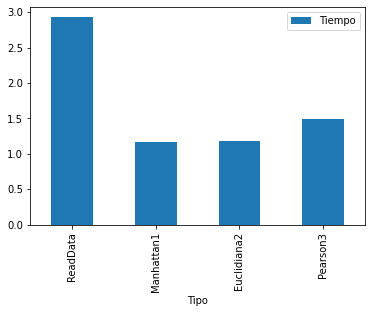

In [7]:
#graficar
grafTiempo.set_index('Tipo').plot(kind='bar')
plt.show()